# Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
def load_images(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("error load image")
        return None, None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

dataset_path = 'dataset/images'
images = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    if len(files) == 0:
        continue
    for f in files:
        _,image = load_images(os.path.join(root, f))
        if image is None:
            continue
        images.append(image)
        labels.append(root.split('/')[-1])

# check data length
print(f"label's length is {len(labels)}")
print(f"image's length is {len(images)}")


label's length is 70
image's length is 70


# Face Detection

In [3]:
# define model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# detect face funct
def detect_faces(img, scale_factor=1.1, min_neighbors = 5, min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        img,
        scaleFactor = scale_factor,
        minNeighbors = min_neighbors,
        minSize = min_size,
    )
    return faces

# crop face funt
def crop_faces(img, faces, return_all = False):
    cropped_faces = []
    selected_faces = []
    if len(faces)>0:
        if return_all:
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))
                cropped_faces.append(img[y:y+h, x:x+w])
        else:
            x, y, w, h = max(faces, key=lambda rect: rect[2]*rect[3])
            selected_faces.append((x, y, w, h))
            cropped_faces.append(img[y:y+h, x:x+w])
    return cropped_faces, selected_faces

# Face Recognition

In [4]:
# resize and Flatten
face_size = (128, 128)

def resize_and_flatten(face):
    face_resized = cv2.resize(face, face_size)
    face_flattened = face_resized.flatten()
    return face_flattened

## Prepare Training Testing Data

In [5]:
# make dataset
x = []
y = []

for image, label in zip(images, labels):
    faces = detect_faces(image)
    cropped_faces, _ = crop_faces(image, faces)
    if len(cropped_faces) > 0:
        face_flattened = resize_and_flatten(cropped_faces[0])
        x.append(face_flattened)
        y.append(label)

x = np.array(x)
y = np.array(y)

In [6]:
# split train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42, stratify=y)

In [7]:
# preprocess image using mean centering 
from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        self.mean_face = np.mean(x, axis=0)
        return self
    
    def transform(self, x):
        return x-self.mean_face

# Train

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# make training pipeline
pipe = Pipeline([
    ('Centering', MeanCentering()),
    ('PCA', PCA(svd_solver='randomized', whiten=True, random_state=42)),
    ('svc', SVC(kernel='linear', random_state=42))
])

# train 
pipe.fit(x_train, y_train)

# evaluate
y_pred = pipe.predict(x_test)
report = classification_report(y_test, y_pred)
print(report)

                         precision    recall  f1-score   support

      Cristiano_Ronaldo       0.38      1.00      0.55         3
          George_W_Bush       0.75      1.00      0.86         3
             Laura_Bush       1.00      1.00      1.00         3
           Lebron_James       0.00      0.00      0.00         3
Muhammad_Natha_Ulinnuha       0.00      0.00      0.00         2
        Serena_Williams       0.67      0.67      0.67         3
         Vladimir_Putin       0.50      0.33      0.40         3

               accuracy                           0.60        20
              macro avg       0.47      0.57      0.50        20
           weighted avg       0.49      0.60      0.52        20



/home/muhnatha/code/Jupyter Notebook/FaceRecognitionCV/cv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/muhnatha/code/Jupyter Notebook/FaceRecognitionCV/cv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/muhnatha/code/Jupyter Notebook/FaceRecognitionCV/cv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

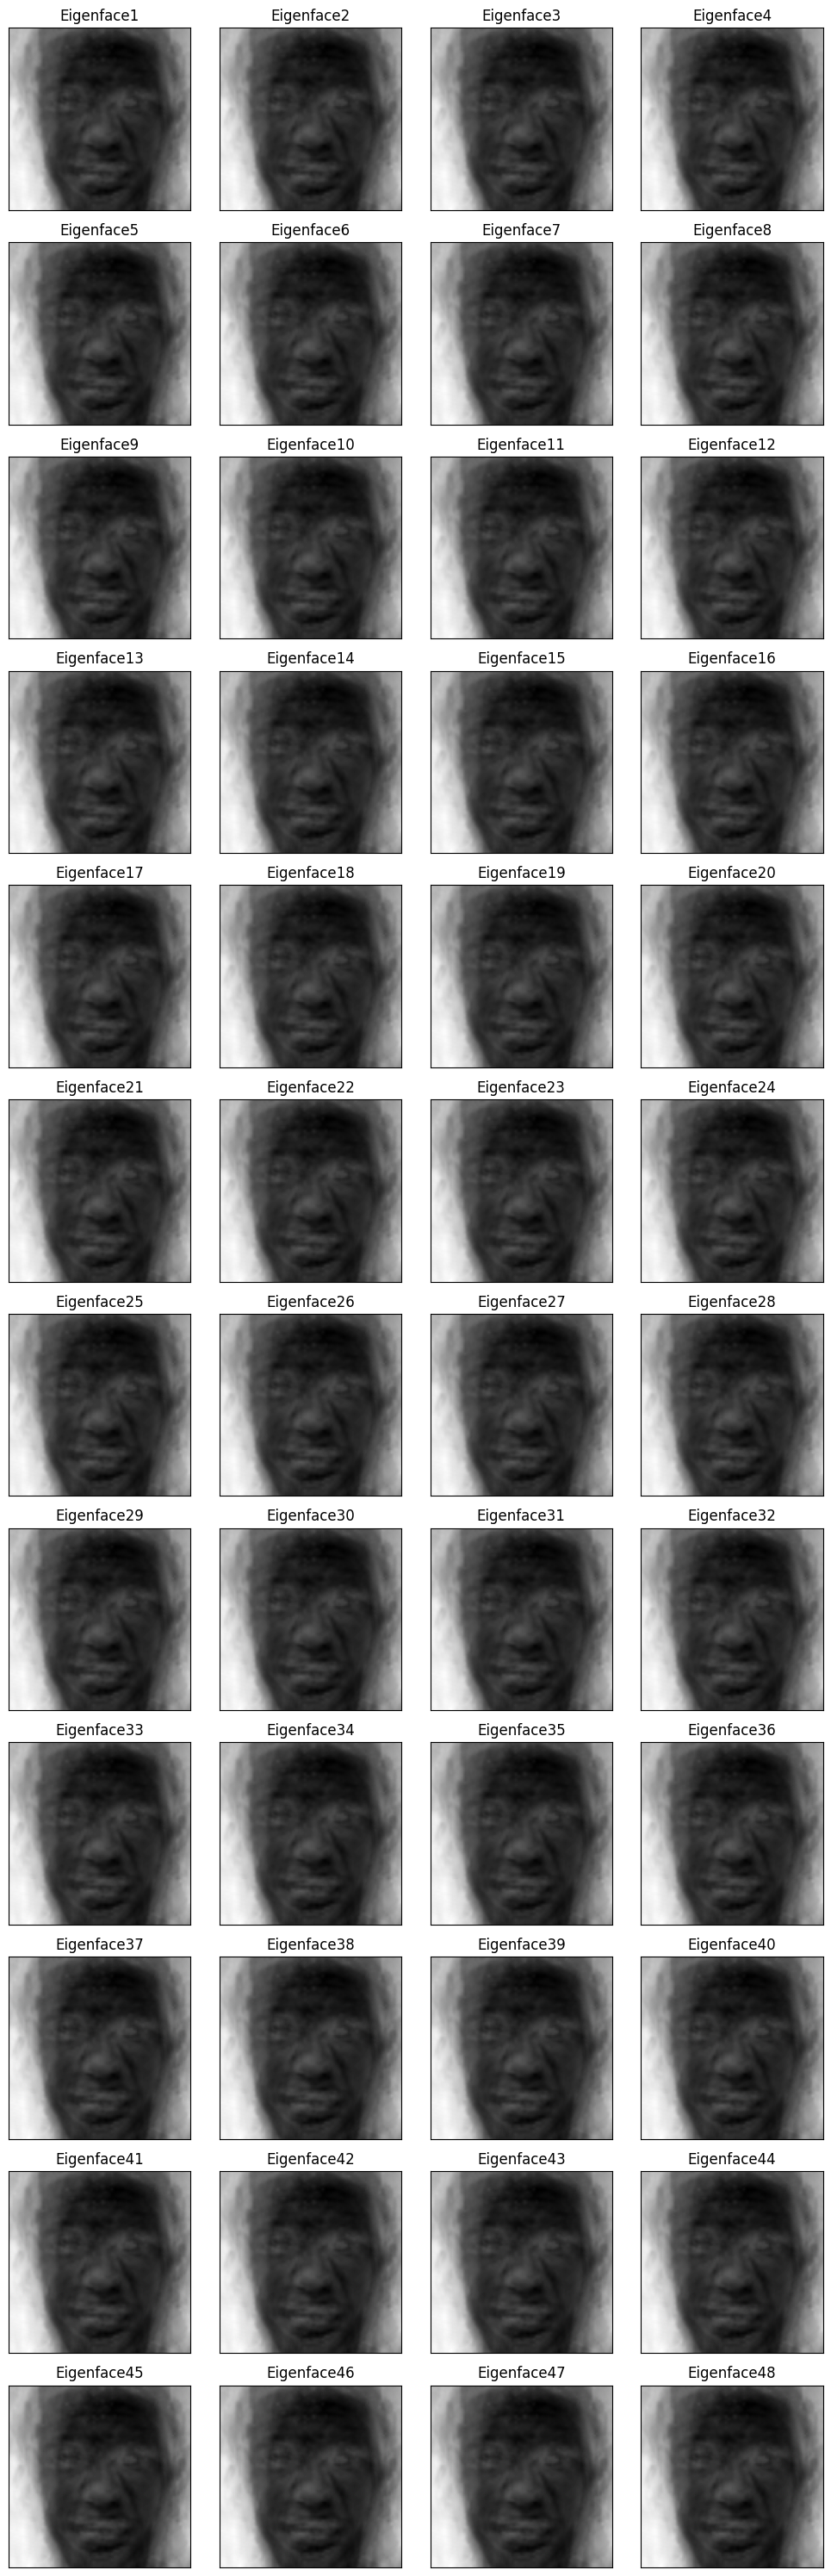

In [9]:
n_components = len(pipe[1].components_)

ncol = 4
nrow = (n_components+ncol-1)//ncol
fig, axes = plt.subplots(
    nrow, 
    ncol, 
    figsize=(10, 2.5*nrow),
    subplot_kw={'xticks':[], 'yticks':[]})

eigenfaces = pipe[1].components_.reshape((n_components, x_train.shape[1]))

for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[1].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface{i+1}')

plt.tight_layout()

In [10]:
# save model
import pickle

with open('eigenfaces_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [11]:
# Combine

def get_eigenface_score(x):
    x_pca = pipe[:2].transform(x)
    eigenface_scores = np.max(pipe[2].decision_function(x_pca), axis=1)
    return eigenface_scores

def eigenface_prediction(gray):
    faces = detect_faces(gray)
    cropped_faces, selected_faces = crop_faces(gray, faces)

    if len(cropped_faces) == 0:
        return 'No face detected.'
    
    x_face = []
    for face in cropped_faces:
        face_flattened = resize_and_flatten(face)
        x_face.append(face_flattened)
    x_face = np.arrat(x_face)
    labels = pipe.predict(x_face)
    scores = get_eigenface_score(x_face)

    return scores, labels, selected_faces

def draw_text(img, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale = 0.6,
              font_thickness = 2,
              text_color = (0, 0, 0),
              text_color_bg = (0, 255, 0)):
    
    x, y = pos
    score_text = f'Score: {score:.2f}'
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
    cv2.rectangle(img, (x, y-h1-h2-25), (x+max(w1, w1)+20, y), text_color_bg, -1)
    cv2.putText(img, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
    cv2.putText(img, score_text, (x+10, y-h2-15), font, font_scale, text_color, font_thickness)

def draw_result(img, scores, labels, coords):
    result_img = img.copy()
    for(x, y, w, h), label, score, in zip(coords, labels, scores):
        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        draw_text(result_img, label, score, pos = (x, y))
    return result_img

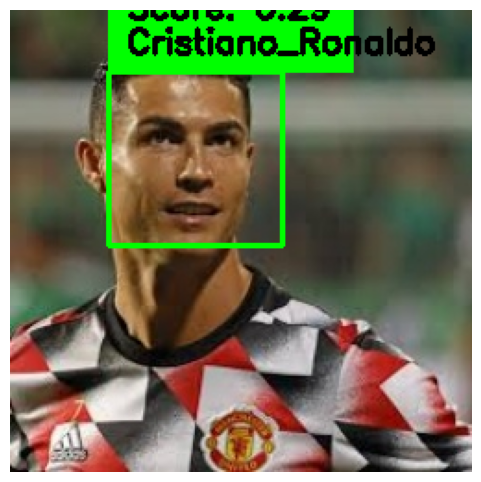

In [13]:
with open('eigenfaces_pipeline.pkl','rb') as f:
    pipe = pickle.load(f)

def runEigenface(img, gray):
    faces = detect_faces(gray)
    cropped_faces, selected_faces = crop_faces(gray, faces)

    if not cropped_faces:
        return 'No face detected.'
    
    x = np.array([resize_and_flatten(face) for face in cropped_faces])

    labels = pipe.predict(x)

    scores = np.max(pipe.decision_function(x), axis = 1)

    return scores, labels, selected_faces

def process_image(img_path):
    img  = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    result = runEigenface(img, gray)
    if isinstance(result, str):
        print(result)
    else:
        scores, labels, selected_faces = result
        out = draw_result(img, scores, labels, selected_faces)
        out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    
        plt.figure(figsize=(6,6))
        plt.imshow(out_rgb)
        plt.axis('off')

img_path = 'dataset/images/Cristiano_Ronaldo/01.jpg'
process_image(img_path)